# Environment Setup



Install required packages

In [1]:
%pip install scipy
%pip install numpy
%pip install pandas
%pip install torchmetrics
%pip install torch
import warnings
warnings.filterwarnings('ignore')

Set the seed for preprocessing the dataset

In [2]:
DataSeed = 28
#Tested seeds: 5, 24, 28, 50, 76

# Mount to Google Drive or Local Drive
Just like in the homeworks

##Mount to Google Drive

In [3]:
# View and modify the working path
import os
from google.colab import drive

# View current working directory
print("Current Working Directory:", os.getcwd())

# Mount Google Drive
drive.mount('/content/gdrive')

# Change working directory to your file position
path = "/content/gdrive/My Drive/BD4H_Project"
os.chdir(path)

# Confirm the change
print("Working Directory:", os.getcwd())

Current Working Directory: /content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Working Directory: /content/gdrive/My Drive/BD4H_Project


##Mount to Local Drive

In [ ]:
import os
path = os.getcwd()
os.chdir(path)

##Debug: This code checks that you have read/write permissions enabled for the folder that the data is written to.  It will return FALSE for the file itself until it is created.
This code is intentionally left in to allow the user to check that they have the correct file structure.

In [ ]:
import os

file_name = "/content/gdrive/My Drive/BD4H_Project/Data/preprocessed/patient_index.npy"

dirs = file_name.split("/")

for i in range(len(dirs)):
    dir_to_check = "/".join(dirs[:i+1])
    print(dir_to_check + " " + str(os.path.exists(dir_to_check)))
    print(dir_to_check + " READ " + str(os.access(dir_to_check, os.R_OK)))
    print(dir_to_check + " WRITE " + str(os.access(dir_to_check, os.W_OK)))

 False
 READ False
 WRITE False
/content True
/content READ True
/content WRITE True
/content/gdrive True
/content/gdrive READ True
/content/gdrive WRITE True
/content/gdrive/My Drive True
/content/gdrive/My Drive READ True
/content/gdrive/My Drive WRITE True
/content/gdrive/My Drive/BD4H_Project True
/content/gdrive/My Drive/BD4H_Project READ True
/content/gdrive/My Drive/BD4H_Project WRITE True
/content/gdrive/My Drive/BD4H_Project/Data True
/content/gdrive/My Drive/BD4H_Project/Data READ True
/content/gdrive/My Drive/BD4H_Project/Data WRITE True
/content/gdrive/My Drive/BD4H_Project/Data/preprocessed True
/content/gdrive/My Drive/BD4H_Project/Data/preprocessed READ True
/content/gdrive/My Drive/BD4H_Project/Data/preprocessed WRITE True
/content/gdrive/My Drive/BD4H_Project/Data/preprocessed/patient_index.npy True
/content/gdrive/My Drive/BD4H_Project/Data/preprocessed/patient_index.npy READ True
/content/gdrive/My Drive/BD4H_Project/Data/preprocessed/patient_index.npy WRITE True


# Data Preprocessing
Note: Data for this project was collected using MIMIC Extract with the default parameters.

Please see
Shirly Wang, Matthew B. A. McDermott, Geeticka Chauhan, Michael C. Hughes, Tristan Naumann,
and Marzyeh Ghassemi. MIMIC-Extract: A Data Extraction, Preprocessing, and Representation
Pipeline for MIMIC-III. arXiv:1907.08322.

https://github.com/MLforHealth/MIMIC_Extract

Note: This code is derived from the project paper's github so as to obtain a matching dataset.  This github may be found at https://github.com/prob-ml/DynST?utm_source=chatgpt.com

In [45]:
import logging
import numpy as np
import pandas as pd
from scipy.special import expit, logit

log = logging.getLogger(__name__)

class preprocessing():
  #Note: Initialization of this class copied from our project paper to obtain the same initial dataset.
  #We may change the input variables if we want to test with a different data subset.
  def __init__(self, work_dir, length_range=[16,128], min_code_counts=100, n_vitals=25, seed=28):
    self.work_dir = work_dir
    file = os.path.join(self.work_dir + "/Data/all_hourly_data.h5")
    #Read data file as dataframe
    self.input = pd.HDFStore(file)
    self.outpath = f"Data/preprocessed"
    self.min_length = length_range[0]
    self.max_length = length_range[1]
    self.min_code_counts = min_code_counts
    self.n_vitals = n_vitals
    self.stay_lengths = None
    self.arrays = {}
    # baseline hazard
    self.H0 = 0.001
    # rate of hazard decay
    self.labda = 0.25
    self.seed = seed
    np.random.seed(seed)
    # static coefficients
    self.beta = np.random.uniform(0.7, 1.2, size=4)
    # dynamic coefficients
    self.gamma = np.random.uniform(0.1, 0.3, size=4)
    # treatment effect on hazards
    self.alpha = -0.5

  def preprocess(self):
    #Obtain index of all patients
    interventions = self.input["interventions"].reset_index()
    stay_lengths = interventions.groupby("subject_id").size()
    #Filter for patients who have stayed between the required length of hours defined in length_range
    self.stay_lengths = stay_lengths[stay_lengths.between(self.min_length, self.max_length)]
    self.stay_lengths.name = "stay_length"
    #Set patient index array to the index of stay lengths
    self.arrays["patient_index"] = self.stay_lengths.index.to_numpy()
    #Process remaining data:
    self.process_patients_demographics()
    self.process_codes()
    self.process_vitals()
    self.arrays["hourly_index"] = self.vitals.index.get_level_values(0)
    #Generate features
    self.features = self.generate_features()
    #Set fixed interventions for calculation of True Average Treatment Effect (defined using two copies of the dataset, one where everyone is treated, and one where everyone is in a control group)
    self.features["treated"] = 1
    self.features["control"] = 0
    #Generate simulated treatment
    simulated_data = self.simulate_treatment(self.features.copy())
    #Extract Treatment
    self.arrays["treatment"] = simulated_data.groupby("subject_id")["A"].any().astype(int).to_numpy()
    #Simulate patient outcomes
    #Debug note: As indicated with the functions following, the rest of this function was copied from our paper's code.
    simulated_data = self.simulate_outcomes(simulated_data)
    self.arrays["survival"] = simulated_data["corrected_survival"].to_numpy()
    self.arrays["hazards"] = simulated_data["hazard"].to_numpy()
    #Write data to csv
    for key, arr in self.arrays.items():
      fname = f"{self.work_dir}/{self.outpath}/{key}.npy"
      np.save(fname, arr)
      simulated_data.to_csv(f"{self.work_dir}/{self.outpath}/df_sim{self.seed}.csv")
      simulated_data.to_csv(self.work_dir + f"/Data/mimic3_df_{self.seed}.csv")


  #Fuctions to process data
  def process_patients_demographics(self):
    demographics = self.input["patients"]
    #Keep just gender and age
    demographics = demographics[["gender", "age"]]
     #Set gender to a binary variable (female = 0, male = 1)
    gender = {"F":0, "M":1}
    #demographics["gender"] = demographics["gender"].map(gender)
    demographics["gender"] = demographics["gender"].apply(lambda x: gender.get(x)).astype(int)
    #Keep patients who are between minimum and maximum age.
    #Note: In the study, the only ages omitted are 90+
    #I've included a minimum age of 18.  This may be omitted.
    minage = 18
    maxage = 90
    demograpcis = demographics[(demographics["age"] >= minage) & (demographics["age"] <= maxage)]
    #Convert Age to deviance from mean age
    meanage = demographics["age"].mean()
    stdage = demographics["age"].std()
    demographics["age"] = demographics["age"].apply(lambda age: ((age -meanage)/stdage))
    #print(meanage)
    #Reset index to subject id
    demographics = demographics.reset_index().set_index("subject_id")[["gender", "age"]]
    #Add current subject ids and data to demographics dataframe, keeping only the filtered patients
    self.demographics = demographics.join(self.stay_lengths, how = "right")
    self.arrays["demographics"] = self.demographics[["gender", "age"]].to_numpy()

  def process_codes(self):
    codes = self.input["codes"].reset_index()[["subject_id", "icd9_codes"]].drop_duplicates(["subject_id"])
    codes = codes.set_index("subject_id").join(self.stay_lengths, how="right")
    codes = codes.explode("icd9_codes")
    code_counts = codes["icd9_codes"].value_counts()
    code_counts = code_counts[code_counts >= self.min_code_counts]
    code_counts.name = "count"
    code_counts = code_counts.to_frame()
    codes = codes.merge(code_counts, left_on="icd9_codes", right_index=True, how="left")
    codes["icd9_codes"] = codes["icd9_codes"].mask(codes["count"].isna())
    codes["icd9_codes"] = codes["icd9_codes"].fillna("unk")
    self.codes = codes
    self.arrays["code_index"] = codes.index.to_numpy()
    self.arrays["code_lookup"], self.arrays["codes"] = np.unique(codes["icd9_codes"], return_inverse=True)

  def process_vitals(self):
    #Obtain vitals and drop extra ids.
    #Note: This fuction is copied from our paper's code, as there is no other, more efficient way to process the vitals in compliance with the paper.
    #Note: Vitals_lab_mean is a multi-index datagrame.  This converts to one index after processing.
    vitals = self.input["vitals_labs_mean"].droplevel(['hadm_id', 'icustay_id'])
    vitals.columns = vitals.columns.get_level_values(0)
    vitals_list = vitals.notna().sum(0).sort_values(ascending=False).head(self.n_vitals).index
    vitals = vitals[vitals_list]
    vitals = vitals.fillna(method="ffill")
    vitals = vitals.fillna(method="bfill")
    mean = np.mean(vitals, axis=0)
    std = np.std(vitals, axis=0)
    vitals = (vitals - mean) / std
    self.vitals = vitals.join(self.stay_lengths, how="right").drop(columns = "stay_length")
    self.arrays["vitals"] = self.vitals.to_numpy()

  #Generates features
  def generate_features(self):
    #Note: This function is copied from our paper's code, as we will be training and testing with the same features
    df = self.demographics[["gender", "stay_length"]]
    df["stay_length"] = (df["stay_length"] - df["stay_length"].mean()) / df["stay_length"].std()
    conf_codes = self.codes.copy()
    conf_codes["hypertension"] = (conf_codes["icd9_codes"] == "4019")
    conf_codes["coronary_ath"] = (conf_codes["icd9_codes"] == "41401")
    conf_codes["atrial_fib"] = (conf_codes["icd9_codes"] == "42731")
    conf_codes = conf_codes.groupby(conf_codes.index)[["hypertension", "coronary_ath", "atrial_fib"]].any().astype(int)
    conf_vitals = self.vitals[["hematocrit", "hemoglobin", "platelets", "mean blood pressure"]]
    #Note on structure of features:
    #Columns, in order:
      #gender: Binary indicator for gender (0 for Female, 1 for Male)
      #stay_length: Deviations from average ICU stay length
      #hypertension: Binary indicator for hypertension
      #coronary_ath: Binary indicator for coronary artery disease
      #atrial_fib: Binary indicator for atrial fibrillation
      #hematocrit: Standardized hematocrit value
      #hemoglobin: Standardized hemoglobin value
      #platelets: Standardized platelets value
      #mean blood pressure: Standardized mean blood pressure value
    return df.join(conf_codes).join(conf_vitals)

  #Simulates giving treatment to patients randomly
  def simulate_treatment(self, dataframe):
    #flatten dataframe
    flat_dataframe = dataframe.groupby(level=0).head(1)
    #Determine if patient is in critical condition (they have at least two of the following: hypertension, coronary_ath, atrial_fib)
    flat_dataframe["critical"] = flat_dataframe[["hypertension", "coronary_ath", "atrial_fib"]].sum(1) >= 2
    #Calculate propensity, as defined in our paper: 0.8 for critical patients, 0.2 for non-critical patients
    flat_dataframe["propensity"] = np.where(flat_dataframe["critical"] == True, 0.8, 0.2)
    #Assign treatment, note that value A is the binary indicator for if a patient gets treatement, A = 1 means treatment is applied, A= 0 means no treatment is applied
    flat_dataframe["A"] = np.random.binomial(1, flat_dataframe["propensity"])
    #Add treatment indicator to dataframe, keeping all rows in the original dataframe
    dataframe = dataframe.join(flat_dataframe["A"], how='left')
    #Forward fill any null values
    dataframe["A"] = dataframe["A"].fillna(method='ffill')
    return dataframe

  #Note: The following functions were copied from the paper's code.
  #Simulates patient outcomes
  def simulate_outcomes(self, df, treatment_col="A"):
     t = df.index.get_level_values(1)
     df["baseline_hazard"] = self.H0 * np.exp(- self.labda * t)
     # apply treatment
     # column can be "A", "control" (all zero), or "treat" (all one)
     df["hazard"] = df["baseline_hazard"] * np.exp(self.alpha * df[treatment_col])
     X = df[["gender", "hypertension", "coronary_ath", "atrial_fib"]]
     #if pd.api.types.is_categorical_dtype(X["gender"]):
     #    X["gender"] = X["gender"].cat.codes  # Convert categories to numerical codes
     df["hazard"] *= np.exp((X * self.beta).sum(1))
     # temporal interaction
     df["critical"] = (df[["hypertension", "coronary_ath", "atrial_fib"]].sum(1) > 1).astype(int)
     df["hazard"] *= np.exp(np.log(1.02) * t * df["critical"])
     # time-varying variables
     V = df[["hematocrit", "hemoglobin", "platelets", "mean blood pressure"]]
     V = V.where(V < 0, 0)**2
     V = V.clip(upper=3)
     df["hazard"] *= np.exp((V * self.gamma).sum(1))
     # stabilize hazards and convert to survival probs
     df["hazard"] = df["hazard"].clip(lower = 1e-8, upper=0.1)
     df["q"] = 1 - df["hazard"]
     df["survival_prob"] = df.groupby("subject_id")["q"].cumprod()
     np.random.seed(self.seed)
     # add jittering
     eps = np.random.normal(loc=0, scale=0.5, size=df["survival_prob"].shape)
     df["survival_prob"] = expit(logit(df["survival_prob"]) + eps)
     df["survives"] = np.random.binomial(1, df["survival_prob"])
     return self.corrected_survival_labels(df)

  @staticmethod
  def corrected_survival_labels(df):
     # identify timestep at which first failure occurs (if applicable)
     first_failure = df.reset_index(level="hours_in")
     first_failure = first_failure[first_failure["survives"] == 0].groupby(level=0).first()
     first_failure = first_failure.set_index("hours_in", append=True)
     first_failure["first_failure"] = True
     first_failure = first_failure["first_failure"]
     # label censored patients
     censored = df.reset_index(level="hours_in")
     censored = (censored["survives"] == 1).groupby(level=0).all()
     censored.name = "censored"
     # combine
     df_sim = df.join(first_failure, how="left")
     df_sim = df_sim.reset_index(level="hours_in").join(censored, how="left").set_index("hours_in", append=True)
     # get corrected survival labels: 1 until first failure, then zero
     df_sim["corrected_survival"] = df_sim["first_failure"]
     df_sim["corrected_survival"] = df_sim.groupby(level=0)["corrected_survival"].bfill()
     df_sim["corrected_survival"] = df_sim["corrected_survival"].fillna(False)
     df_sim["corrected_survival"] = (df_sim["corrected_survival"] | df_sim["censored"]).astype(int)
     df_sim["corrected_survival"] = df_sim["corrected_survival"].mask(df_sim["first_failure"].fillna(False), 0)
     return df_sim

  @staticmethod
  def rmst(df, tau):
    restr = df.groupby(level=0)["corrected_survival"].head(tau)
    rst = restr.groupby(level=0).sum()
    return rst.to_numpy()

Call Data Preprocessing



In [ ]:
pipeline = preprocessing(path, seed=DataSeed)
pipeline.preprocess()

#Read preprocessed Dataset

Based on Dataset.py

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class ReadDataset(Dataset):
  def __init__(self, work_dir, seed, intervention=None, causal=False):
      filedirectory = f"{work_dir}/Data/preprocessed"
      self.data = {}
      #Read preprocessed .npy files
      for filename in os.listdir(filedirectory):
        if filename.endswith(".npy"):
          self.data[filename.split(".")[0]] = np.load(f"{filedirectory}/{filename}", allow_pickle=True)

      #Set intervention.  TRUE indicates the treatment group, FALSE indicates the control group
      self.intervention = intervention
      #Store relevant data (patient index, codes, code lookup, the number of codes, number of vitals, and number of demographics)
      self.idx = self.data["patient_index"]
      self.codes = self.data["codes"]
      self.code_lookup = np.insert(self.data["code_lookup"],0,"pad")
      self.code_count = len(self.code_lookup)
      self.vital_count = self.data["vitals"].shape[1]
      self.demo_count = self.data["demographics"].shape[1]
      self.pad_value = -100
      if self.code_lookup.dtype == object:
          self.code_lookup = self.code_lookup.tolist()

  def __getitem__(self, index):
      item = {}
      hour = self.idx[index]
      #Grab just the treatment for the hourly index if the intervention is none
      if self.intervention is None:
        item["treatment"] = self.data["treatment"][index]
      #Else set the treatment to the binary treatment indicator
      else:
        item["treatment"] = int(self.intervention)
      #grab all patient information at the hourly index
      # Changed self.f to self.data to access the loaded data
      item["codes"] = self.padcount(self.data["codes"][self.data["code_index"] == hour]).clone().detach()
      item["demographics"] = self.data["demographics"][index]
      item["vitals"] = torch.tensor(self.data["vitals"][self.data["hourly_index"]==hour]).float()
      item["survival"] = torch.tensor(self.data["survival"][self.data["hourly_index"]==hour])

      return item

  def __len__(self):
      return len(self.data["treatment"])

  def padcount(self, records):
    #get count of each record
    records = np.bincount(records)
    #Pad each vector to the length of all possible codes by adding 0s to the end of the vector
    padded = np.zeros(self.code_count)
    padded[:len(records)] = records
    #Return as a float tensor
    return torch.from_numpy(padded).float()

  def padorder(batch, pad_index, causal=False):
    #Pads batch data
    result = {}
    treatment = torch.tensor(np.array([item["treatment"] for item in batch]))
    demog = torch.tensor(np.array([item["demographics"] for item in batch])).float()
    if causal:
      result["static"] = torch.cat((demog, treatment.unsqueeze(1)), dim=1)
      result["survival"] = pad_sequence([item["survival"] for item in batch], batch_first=True, padding_value=pad_index)
      result["vitals"] = pad_sequence([item["vitals"] for item in batch], batch_first=True, padding_value=pad_index)
      # Pad survival and vitals to 127 (max number of hours)
      result["survival"] = torch.nn.functional.pad(result["survival"], (0, 127 - result["survival"].shape[1]), value=pad_index)
      result["vitals"] = torch.nn.functional.pad(result["vitals"], (0, 0, 0, 127 - result["vitals"].shape[1]), value=pad_index)

    else:
      result["static"] = torch.cat((demog, treatment.unsqueeze(1)), dim=1)
      result["survival"] = torch.tensor([item["survival"][-1] for item in batch])  # Take only last value
      #append to result
      result["vitals"] = pad_sequence([item["vitals"] for item in batch], batch_first=True, padding_value=pad_index)
    result["codes"] = torch.stack([item["codes"] for item in batch])



    return result


In [5]:
dataset = ReadDataset(work_dir=path, seed=DataSeed)
dataset_pe = ReadDataset(work_dir=path, seed=DataSeed,causal=True)

#Dataset Statistics

In [ ]:
#Dataset Shape and example Data
print(len(dataset))
sample = dataset[0]  # Get the first sample

print("Treatment:", sample["treatment"])
print("Codes shape:", sample["codes"].shape)
print("Demographics shape:", sample["demographics"].shape)
print("Vitals shape:", sample["vitals"].shape)
print("Survival shape:", sample["survival"].shape)

30323
Treatment: 1
Codes shape: torch.Size([517])
Demographics shape: (2,)
Vitals shape: torch.Size([41, 25])
Survival shape: torch.Size([41])


In [ ]:
#Descriptive statistics about our dataset
import numpy as np
import pandas as pd

#Read our preprocessed csv.  We only need to do this to get the boolean for the critical condition of the patient. (This is part of the hazard function in the dataset used in the machine learning model)
statistics_dataset = pd.read_csv(f"{path}/Data/preprocessed/df_sim28.csv", index_col=0)
statistics_dataset2 = statistics_dataset.copy()
#Heart failure dataset, used to get the average number of hours before heart failure was observed
heart_failure_dataset = statistics_dataset[statistics_dataset['first_failure'] == 1]
#Group by patient.  We keep only the last index of each, as the only variable statistic we are concerned with in this block of code is the hour of the last record for each patient.
statistics_dataset = statistics_dataset.groupby("subject_id").tail(1)

#Basics of Dataset
print(f"Number of patients: {len(dataset)}")
print(f"Number of codes: {dataset.code_count}")
print(f"Number of hourly vitals records: {len(dataset.data['vitals'])}")
print(f"Number of records: {len(dataset.data['codes'])}")

print("")

#Demographic breakdown on patients
print(f"Demographics:")
num_male = (dataset.data['demographics'][:, 0] == 0).sum()
num_female = (dataset.data['demographics'][:, 0] == 1).sum()
percent_male = (num_male / len(dataset.data['demographics'])) * 100
percent_female = (num_female / len(dataset.data['demographics'])) * 100
print(f"  Number of Male Patients: {num_male}, Percentage of Male Patients: {percent_male:.4f}%")
print(f"  Number of Female Patients: {num_female}, Percentage of Female Patients: {percent_female:.4f}%")
#Note: The average age of the dataset was determined in data preprocessing.  Since the age is normalized in this step, the average age was copied from preprocessing and pasted below
print(f"  Average Age: 75")
#print("Standard Deviaion: 55.85")
print("")

#Split of Treatment vs Test samples.
num_treatment = (dataset.data['treatment'] == 1).sum()
num_control = (dataset.data['treatment'] == 0).sum()
percent_treatment = (num_treatment / len(dataset.data['treatment'])) * 100
percent_control = (num_control / len(dataset.data['treatment'])) * 100
print(f"  Treatment Split: {num_treatment}, Percentage of Treatment: {percent_treatment:.4f}%")
print(f"  Control Split: {num_control}, Percentage of Control: {percent_control:.4f}%")
print("")

#Number of patients with critical condition
num_critical = (statistics_dataset['critical']==1).sum()
num_noncritical = (statistics_dataset['critical']==0).sum()
percent_critical = (num_critical / len(statistics_dataset['critical'])) * 100
percent_noncritical = (num_noncritical / len(statistics_dataset['critical'])) * 100
print(f"  Critical Condition Split: {num_critical}, Percentage of Critical: {percent_critical:.4f}%")
print(f"  Non-Critical Condition Split: {num_noncritical}, Percentage of Non-Critical: {percent_noncritical:.4f}%")
print("")

#Survival split
#Note: This is the same as the value of the censored column, as false indicates that we observe patient heart failure.
num_survived = (statistics_dataset['censored'] == 1).sum()
num_dead = (statistics_dataset['censored'] == 0).sum()
percent_survived = (num_survived / len(statistics_dataset['censored'])) * 100
percent_dead = (num_dead / len(statistics_dataset['censored'])) * 100
print(f"  Number of patients that did not experience heart failure: {num_survived}, Percentage of patients that did not experience heart failure: {percent_survived:.4f}%")
print(f"  Number of patients that experienced heart failure: {num_dead}, Percentage of patients that experienced heart failure: {percent_dead:.4f}%")
#Further split heart failure into once or multiple times
#Patients that experienced heart failure
heart_failure = statistics_dataset2[statistics_dataset2['survives'] == 0]
#Group by patient, get how many times each patient had heart failure
num_heart_failure = heart_failure.groupby('subject_id').size()
#Patients that experienced heart failure once
num_heart_failure_once = len(num_heart_failure[num_heart_failure == 1])
#Patients that experienced heart failure more than once
num_heart_failure_more = len(num_heart_failure[num_heart_failure > 1])
#Patients that did not experience heart failure (group survival by patient, where minimum is 1)
true_false_heart_failure = statistics_dataset2.groupby('subject_id')['survives'].min()
num_heart_failure_none = len(true_false_heart_failure[true_false_heart_failure == 1])
print(f"  Heart Failure Split:")
print(f"    Number of patients that experienced heart failure once: {num_heart_failure_once}")
print(f"    Number of patients that experienced heart failure more than once: {num_heart_failure_more}")

#Number of patients that actually died.  Denoted as patients that had not survived in their final record.
num_stayed_dead = (statistics_dataset['survives'] == 0).sum()
percent_stayed_dead = (num_stayed_dead / len(statistics_dataset['survives'])) * 100
print(f"  Number of patients that died: {num_stayed_dead}, Percentage of patients that died: {percent_stayed_dead:.4f}%")
print("")

#We can add whatever other summary statistics we want, really.  Most common code, Average number of hours stayed, etc.
#Misc
print("Misc:")
#Stay Length
avg_hours = statistics_dataset['hours_in'].mean()
print(f"  Average Hours Stayed: {avg_hours:.2f}")
max_hours = statistics_dataset['hours_in'].max()
num_max = (statistics_dataset['hours_in'] == max_hours).sum()
min_hours = statistics_dataset['hours_in'].min()
num_min = (statistics_dataset['hours_in'] == min_hours).sum()
print(f"  Minimum Hours Stayed: {min_hours}")
print(f"  Number of Patients with Minimum Hours Stayed: {num_min}")
print(f"  Maximum Hours Stayed: {max_hours}")
print(f"  Number of Patients with Maximum Hours Stayed: {num_max}")
#Censored vs uncensored split:
num_censored = (statistics_dataset2['censored'] == 1).sum()
num_uncensored = (statistics_dataset2['censored'] == 0).sum()
percent_censored = (num_censored / len(statistics_dataset2['censored'])) * 100
percent_uncensored = (num_uncensored / len(statistics_dataset2['censored'])) * 100
num_censored_patients = int(percent_censored * 30323 /100)
num_uncensored_patients = int(percent_uncensored * 30323/ 100)
print(f"  Censored Split: {num_censored_patients}, Percentage of Censored: {percent_censored:.4f}%")
print(f"  Uncensored Split: {num_uncensored_patients}, Percentage of Uncensored: {percent_uncensored:.4f}%")
#Time before first heart failure where observed
avg_hours_before_failure = heart_failure_dataset['hours_in'].mean()
print(f"  Average Hours Before Heart Failure in patients that experienced heart failure: {avg_hours_before_failure:.2f}")
max_hours_before_failure = heart_failure_dataset['hours_in'].max()
num_max_hours_before_failure = (heart_failure_dataset['hours_in'] == max_hours_before_failure).sum()
print(f"  Maximum Hours Before Heart Failure in patients that experienced heart failure: {max_hours_before_failure}")
print(f"  Number of Patients with Maximum Hours Before Heart Failure in patients that experienced heart failure: {num_max_hours_before_failure}")
min_hours_before_failure = heart_failure_dataset['hours_in'].min()
num_min_hours_before_failure = (heart_failure_dataset['hours_in'] == min_hours_before_failure).sum()
print(f"  Minimum Hours Before Heart Failure in patients that experienced heart failure: {min_hours_before_failure}")
print(f"  Number of Patients with Minimum Hours Before Heart Failure in patients that experienced heart failure: {num_min_hours_before_failure}")
print("")


Number of patients: 30323
Number of codes: 517
Number of hourly vitals records: 1548638
Number of records: 319676

Demographics:
  Number of Male Patients: 13123, Percentage of Male Patients: 43.2774%
  Number of Female Patients: 17200, Percentage of Female Patients: 56.7226%
  Average Age: 75

  Treatment Split: 10909, Percentage of Treatment: 35.9760%
  Control Split: 19414, Percentage of Control: 64.0240%

  Critical Condition Split: 8108, Percentage of Critical: 26.7388%
  Non-Critical Condition Split: 22215, Percentage of Non-Critical: 73.2612%

  Number of patients that did not experience heart failure: 11706, Percentage of patients that did not experience heart failure: 38.6044%
  Number of patients that experienced heart failure: 18617, Percentage of patients that experienced heart failure: 61.3956%
  Heart Failure Split:
    Number of patients that experienced heart failure once: 7173
    Number of patients that experienced heart failure more than once: 11444
  Number of patie

##Plot statistics

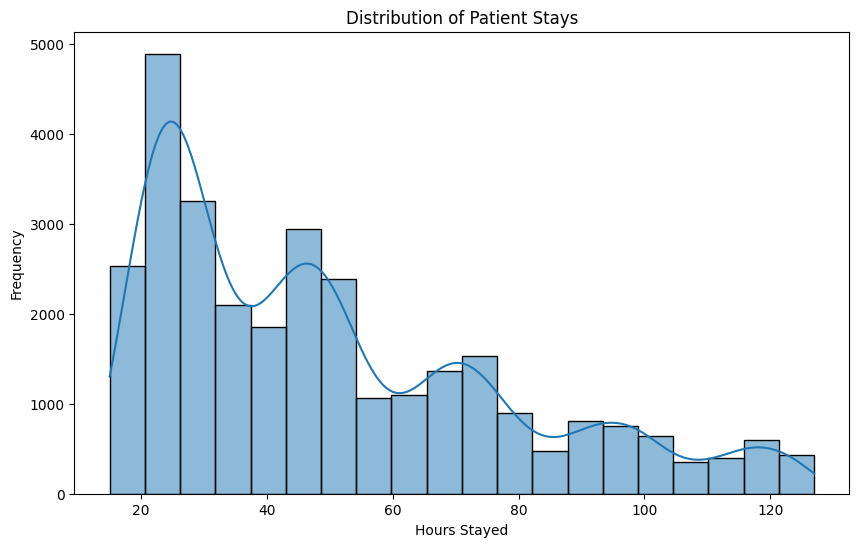

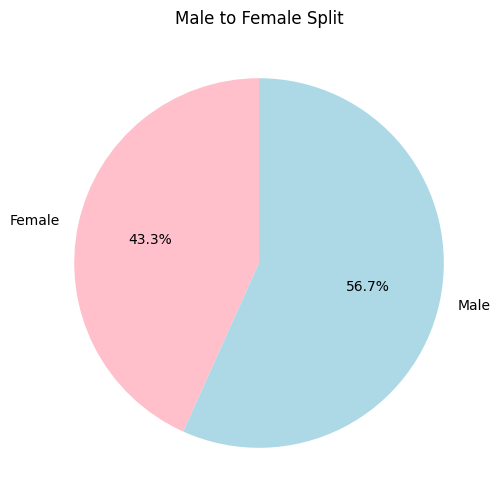

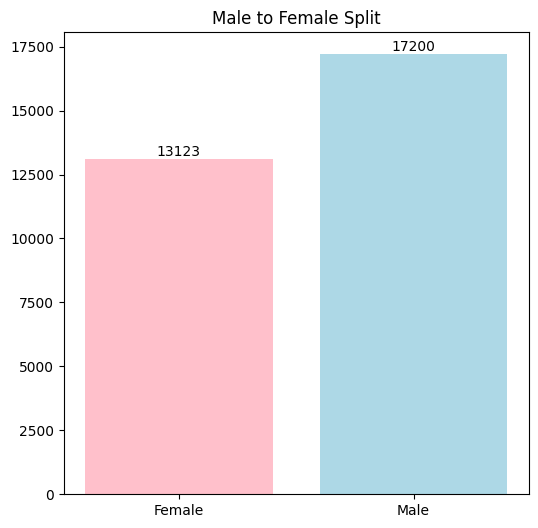

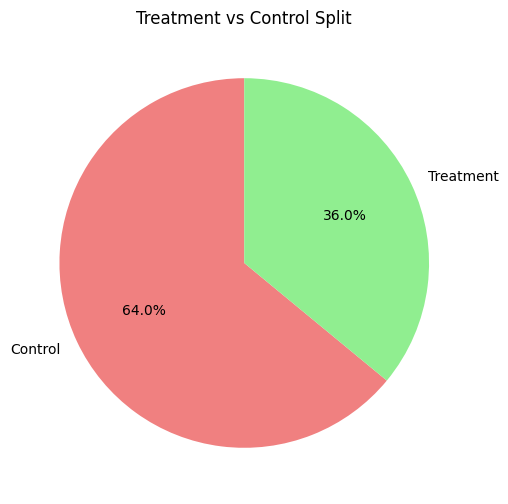

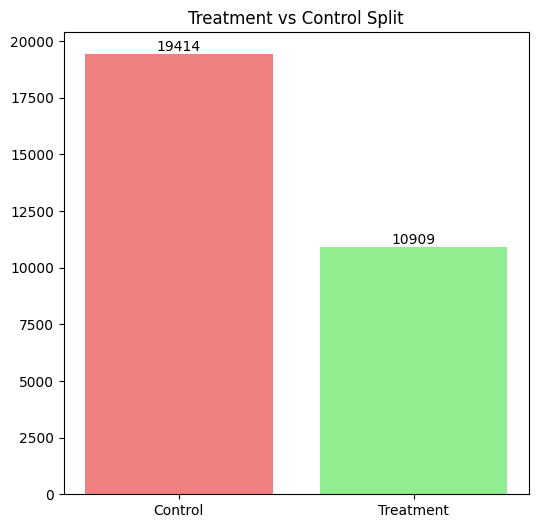

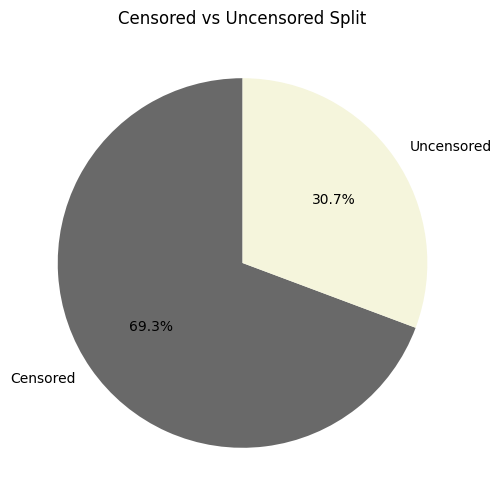

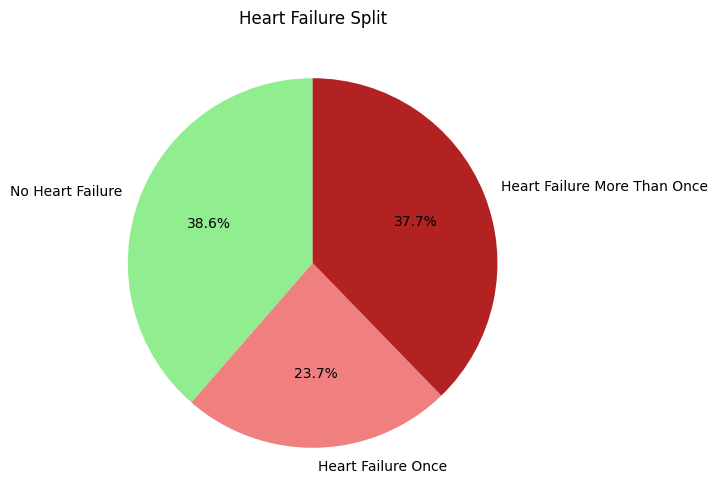

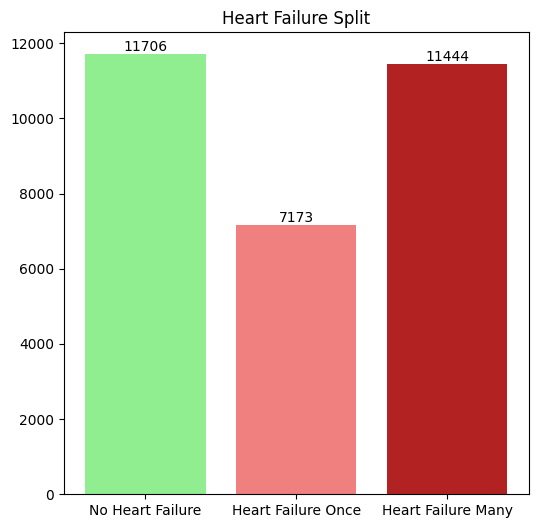

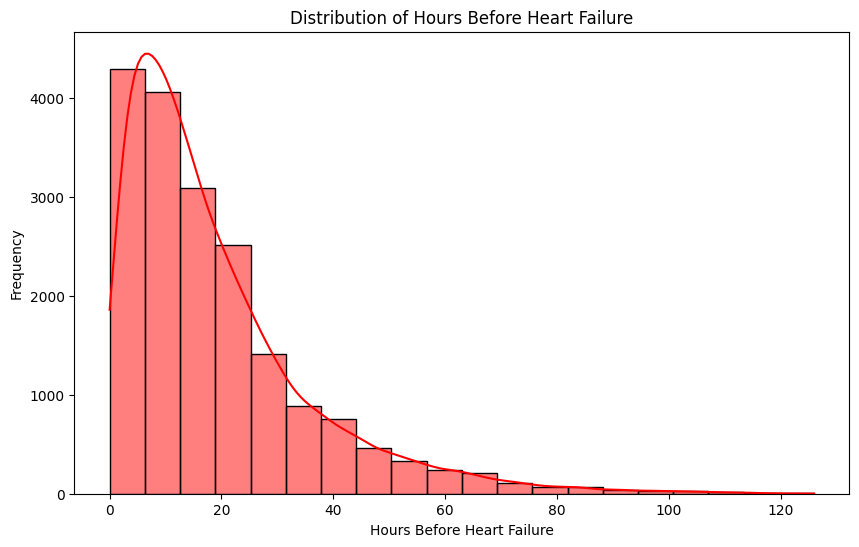

In [ ]:
#Plot these statistics:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

statistics_dataset = pd.read_csv(f"{path}/Data/preprocessed/df_sim28.csv", index_col=0)
statistics_tail = statistics_dataset.groupby("subject_id").tail(1) #Used to get the last index for each patient for stay duration only

#Distribution of patient stays
staylengths = statistics_tail['hours_in']
plt.figure(figsize=(10, 6))
sns.histplot(staylengths, bins=20, kde=True)
plt.xlabel('Hours Stayed')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Stays')
plt.show()

#Patient Demographics:
#Male vs Female split (percentages)
demographics = dataset.data['demographics']
plt.figure(figsize=(6, 6))
labels = ['Female', 'Male']
colors = ['pink', 'lightblue']
plt.pie(np.array([np.sum(demographics[:, 0] == 0), np.sum(demographics[:, 0] == 1)]), labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Male to Female Split')
plt.show()
#(Numbers)
plt.figure(figsize=(6, 6))
labels = ['Female', 'Male']
plt.bar(labels, [np.sum(demographics[:, 0] == 0), np.sum(demographics[:, 0] == 1)], color=colors)
for i in range(2):
    plt.text(i, [np.sum(demographics[:, 0] == 0), np.sum(demographics[:, 0] == 1)][i], [np.sum(demographics[:, 0] == 0), np.sum(demographics[:, 0] == 1)][i], ha='center', va='bottom')
plt.title('Male to Female Split')
plt.show()

#Treatment vs control split (percentages)
treatment = dataset.data['treatment']
plt.figure(figsize=(6, 6))
labels = ['Control', 'Treatment']
colors = ['lightcoral', 'lightgreen']
plt.pie(np.array([np.sum(treatment == 0), np.sum(treatment == 1)]), labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Treatment vs Control Split')
plt.show()
#(Numbers)
plt.figure(figsize=(6, 6))
labels = ['Control', 'Treatment']
plt.bar(labels, [np.sum(treatment == 0), np.sum(treatment == 1)],color=colors)
for i in range(2):
    plt.text(i, [np.sum(treatment == 0), np.sum(treatment == 1)][i], [np.sum(treatment == 0), np.sum(treatment == 1)][i], ha='center', va='bottom')
plt.title('Treatment vs Control Split')
plt.show()

#Percentage of censored patients
censored = statistics_dataset['censored']
plt.figure(figsize=(6, 6))
labels = ['Censored', 'Uncensored']
colors = ['dimgray', 'beige']
plt.pie(np.array([np.sum(censored == 0), np.sum(censored == 1)]), labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Censored vs Uncensored Split')
plt.show()

#Patients that experienced heart failure
heart_failure = statistics_dataset[statistics_dataset['survives'] == 0]
#Group by patient, get how many times each patient had heart failure
num_heart_failure = heart_failure.groupby('subject_id').size()
#Patients that experienced heart failure once
num_heart_failure_once = len(num_heart_failure[num_heart_failure == 1])
#Patients that experienced heart failure more than once
num_heart_failure_more = len(num_heart_failure[num_heart_failure > 1])
#Patients that did not experience heart failure (group survival by patient, where minimum is 1)
true_false_heart_failure = statistics_dataset.groupby('subject_id')['survives'].min()
num_heart_failure_none = len(true_false_heart_failure[true_false_heart_failure == 1])
#plot
plt.figure(figsize=(6, 6))
labels = ['No Heart Failure', 'Heart Failure Once', 'Heart Failure More Than Once']
colors = ['lightgreen', 'lightcoral', 'firebrick']
plt.pie(np.array([num_heart_failure_none, num_heart_failure_once, num_heart_failure_more]), labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Heart Failure Split')
plt.show()
plt.figure(figsize=(6, 6))
labels = ['No Heart Failure', 'Heart Failure Once', 'Heart Failure Many']
plt.bar(labels, [num_heart_failure_none, num_heart_failure_once, num_heart_failure_more], color=colors)
for i in range(3):
    plt.text(i, [num_heart_failure_none, num_heart_failure_once, num_heart_failure_more][i], [num_heart_failure_none, num_heart_failure_once, num_heart_failure_more][i], ha='center', va='bottom')
plt.title('Heart Failure Split')
plt.show()

#first heart failure times
first_failure = statistics_dataset[statistics_dataset['first_failure'] == 1]
first_failure_times = first_failure['hours_in']
plt.figure(figsize=(10, 6))
sns.histplot(first_failure_times, bins=20, kde=True, color='red')
plt.xlabel('Hours Before Heart Failure')
plt.ylabel('Frequency')
plt.title('Distribution of Hours Before Heart Failure')
plt.show()



#Performance Metrics

In [2]:
import torch
from torchmetrics import Metric
"""
#We can include whatever performance metrics we want.
#Input metric: Padding for our dataset (pad=pad).

#In survival analysis, the concordance index (C-index) measures how well a model predicts the relative ordering of event times, essentially assessing the model's ability to discriminate between individuals with different event risk

What Concordance Index  measures:
The C-index evaluates a model's ability to correctly predict the order of events, rather than the exact timing of events.
How it works:
It compares the predicted risk scores (or hazard scores) of pairs of individuals to their actual event times.
Concordant pairs:
A pair is considered concordant if the individual with the higher predicted risk score experiences the event before the individual with the lower predicted risk score.
Calculation:
The C-index is calculated as the proportion of concordant pairs among all comparable pairs in the dataset.

"""


class Metrics():
  def __init__(self, pad=-100, alpha=0.01):
    #Set Padding
    self.pad = pad
    self.alpha = alpha
    #Define error and total states as a tensor of zeroes on the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.error = torch.tensor(0.0, device=device)  # Initialize on the correct device
    self.total = torch.tensor(0.0, device=device)
    #Define observed, true, and predicted as empty lists
    self.observed = []
    self.true = []
    self.predicted = []


  #Loss Functions
  def ordinal_survival(self, s_hat, y):
    nlog_alive = -torch.log(s_hat)
    nlog_dead = -torch.log(1 - s_hat)
    loss = 0
    loss += nlog_alive * torch.where(y==self.pad, 0, y)
    loss += nlog_dead * torch.where(y==self.pad, 0, (1-y))
    return loss.sum() / (y != self.pad).sum()

  def combined_loss(self, s_hat, y):
    a = self.alpha
    ordinal_loss = self.ordinal_survival(s_hat, y)
    mae_loss = self.MAE_compute(s_hat, y)
    return (1 - a) * ordinal_loss + a * mae_loss

  #Concordance Index
  def concordance_index(self, predictions, event_times, event_indicators):
    n = len(predictions)
    concordant_pairs = 0
    total_comparable_pairs = 0

    for i in range(n):
        for j in range(i + 1, n):
            # Check if the pair is comparable
            if event_times[i] < event_times[j] and event_indicators[i] == 1:
                total_comparable_pairs += 1

                # Check if the pair is concordant
                if predictions[i] > predictions[j]:
                    concordant_pairs += 1
            elif event_times[j] < event_times[i] and event_indicators[j] == 1:
                total_comparable_pairs += 1

                # Check if the pair is concordant
                if predictions[j] > predictions[i]:
                    concordant_pairs += 1

    # Handle cases where there are no comparable pairs
    if total_comparable_pairs == 0:
        return 0  # or np.nan (depending on your preference)

    # Calculate the C-index
    c_index = concordant_pairs / total_comparable_pairs
    return c_index

  def CI_compute(self, predictions, event_times, event_indicators):
        return self.concordance_index(predictions, event_times, event_indicators)




  #Mean Absolute Error
  def MAE_compute(self, preds, targets):
    # Ensure targets are on the same device as preds
    targets = targets.to(preds.device)
    #Reshape survival to have 2 dimensions
    targets = targets.unsqueeze(1)
    #We denote the survival as observed instead of censored if we see death (corrected survival) is 0 in any column in the target.
    observed = (targets==0).any(1).int()
    #Get the estimated survival time (sum of estimated survival times)
    t_hat = torch.where(targets==self.pad, 0, preds).sum(1)
    #Get the actual survival times
    t = torch.where(targets==self.pad, 0, targets).sum(1)
    #An array of zeroes, used in calculations
    zeroes = torch.zeros(t.shape, device=preds.device)
    #Calculate error where survival is observed
    observed_error =  torch.abs(t_hat - t) *observed
    #Calculate error where survival is censored
    censored_error = torch.maximum(zeroes, t - t_hat) * (1-observed)
    #Calculate the mean absolute error:
    self.error += observed_error.sum() + censored_error.sum()
    #Total: the total number of elements present in t.
    self.total += t.numel()
    return self.error / self.total





#Machine Learning Model

##Mortality Prediction

###Initialize Model

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32  # You can adjust this based on memory constraints

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: ReadDataset.padorder(x, pad_index=-100)  # Handles padding
)

for batch in dataloader:
    print("Static shape:", batch["static"].shape)  # Demographics + Treatment
    print("Vitals shape:", batch["vitals"].shape)  # Time-series vitals
    print("Codes shape:", batch["codes"].shape)    # Medical codes
    print("Survival shape:", batch["survival"].shape)  # Survival labels
    break  # Show only first batch

Static shape: torch.Size([32, 3])
Vitals shape: torch.Size([32, 128, 25])
Codes shape: torch.Size([32, 517])
Survival shape: torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SurvivalTransformer(nn.Module):
    def __init__(self,
                 static_dim: int,          # e.g., demographics
                 dynamic_dim: int,         # e.g., vitals/labs
                 num_codes: int,           # e.g., number of unique ICD codes
                 d_model: int = 128,
                 nhead: int = 4,
                 num_layers: int = 2,
                 dim_feedforward: int = 256,
                 dropout: float = 0.1):
        super(SurvivalTransformer, self).__init__()

        # Project dynamic inputs to d_model dimension
        self.dynamic_proj = nn.Linear(dynamic_dim, d_model)

        # Embedding for discrete codes (like ICD codes)
        self.code_embedding = nn.Embedding(num_codes, d_model, padding_idx=0)

        # Transformer encoder for dynamic sequence
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # MLP head for survival prediction
        self.fc = nn.Sequential(
            nn.Linear(d_model * 2 + static_dim + 1, dim_feedforward),
            nn.ReLU(inplace=False),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, 1),
            nn.Sigmoid()  # for survival probability between 0 and 1
        )

    def forward(self, dynamic, codes, static):
        # dynamic: (batch, time, features)
        # codes: (batch, num_codes)
        # static: (batch, static_dim)

        # Project dynamic features
        x_dyn = self.dynamic_proj(dynamic)  # (batch, time, d_model)
        x_dyn = self.transformer_encoder(x_dyn)  # (batch, time, d_model)

        # Aggregate dynamic representation (e.g., last timestep)
        dyn_rep = x_dyn[:, -1, :]  # (batch, d_model)

        # Embed codes and aggregate
        code_embed = self.code_embedding(codes)  # (batch, num_codes, d_model)
        code_rep = code_embed.mean(dim=1)  # (batch, d_model)

        # Concatenate all representations
        fused = torch.cat([dyn_rep, code_rep, static], dim=1)  # (batch, d_model*2 + static_dim)
        out = self.fc(fused).squeeze(1)  # (batch,)
        return out


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_results(k_folds, train_losses, val_losses, train_maes, val_maes, outputs, survival):
    # Plot loss

    plt.figure(figsize=(12, 5))
    for i in range(k_folds):
        plt.plot(train_losses[i], label=f"Fold {i+1} Train Loss")
        plt.plot(val_losses[i], label=f"Fold {i+1} Val Loss", linestyle='--')
    plt.title(f"Mortality Prediction Loss over Epochs for seed {DataSeed}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    #Save loss
    loss_path = f"Outputs/Graphs/mp_loss_curve_{DataSeed}.png"
    plt.savefig(loss_path)

    # Plot MAE
    plt.figure(figsize=(12, 5))
    for i in range(k_folds):
        plt.plot(train_maes[i], label=f"Fold {i+1} Train MAE")
        plt.plot(val_maes[i], label=f"Fold {i+1} Val MAE", linestyle='--')
    plt.title(f"Mortality Prediction Mean Absolute Error over Epochs for seed {DataSeed}")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()
    #Save MAE
    mae_path = f"Outputs/Graphs/mp_mae_curve_{DataSeed}.png"
    plt.savefig(mae_path)



    # After validation loop
    y_true = survival.cpu().numpy()
    y_pred = (outputs > 0.5).int().cpu().numpy()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for seed {DataSeed}")
    plt.show()
    #Save Confusion Matrix
    cm_path = f"Outputs/Graphs/mp_confusion_{DataSeed}.png"
    plt.savefig(cm_path)

###Train and Plot

Fold 1/5
  Epoch 1, Train Loss: 0.6004, Train Mean Absolute Error: 7.6711, Time: 150.73 sec
  Epoch 2, Train Loss: 0.5734, Train Mean Absolute Error: 7.5068, Time: 135.80 sec
  Epoch 3, Train Loss: 0.5597, Train Mean Absolute Error: 7.4454, Time: 134.37 sec
  Epoch 4, Train Loss: 0.5563, Train Mean Absolute Error: 7.4357, Time: 135.03 sec
  Epoch 5, Train Loss: 0.5518, Train Mean Absolute Error: 7.4500, Time: 141.40 sec
  Epoch 6, Train Loss: 0.5498, Train Mean Absolute Error: 7.4605, Time: 141.85 sec
  Epoch 7, Train Loss: 0.5490, Train Mean Absolute Error: 7.4897, Time: 142.47 sec
  Epoch 8, Train Loss: 0.5475, Train Mean Absolute Error: 7.4790, Time: 143.86 sec
  Epoch 9, Train Loss: 0.5481, Train Mean Absolute Error: 7.4756, Time: 142.06 sec
  Epoch 10, Train Loss: 0.5457, Train Mean Absolute Error: 7.4779, Time: 142.50 sec
  Fold 1 Val Loss: 0.5491, Val Mean Absolute Error: 7.4833
Fold 2/5
  Epoch 1, Train Loss: 0.6029, Train Mean Absolute Error: 7.7783, Time: 138.49 sec
  Epoch 2

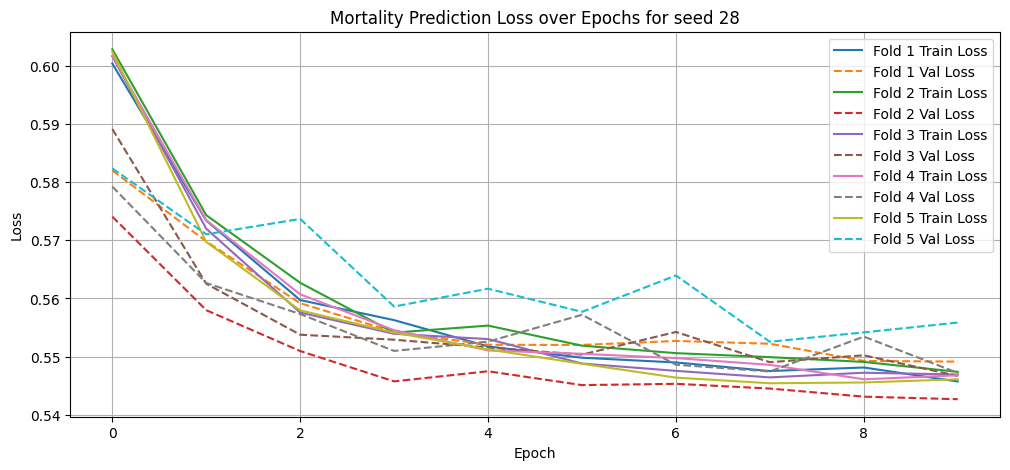

<Figure size 640x480 with 0 Axes>

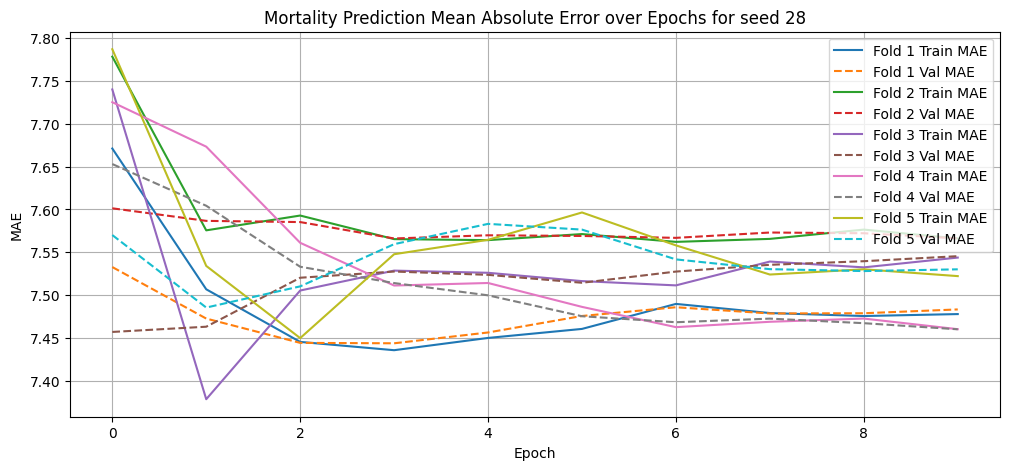

<Figure size 640x480 with 0 Axes>

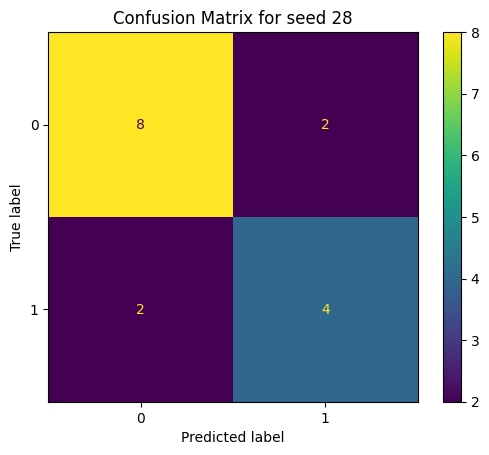

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import time

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Loop
num_epochs = 10

train_losses = [[] for _ in range(k_folds)]
val_losses_main = [[] for _ in range(k_folds)]
train_maes = [[] for _ in range(k_folds)]
val_maes_main = [[] for _ in range(k_folds)]

with open(f"Outputs/mp_train_val_metrics_{DataSeed}.txt", "w") as f:

  for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
      print(f"Fold {fold + 1}/{k_folds}")
      f.write(f"Fold {fold + 1}/{k_folds}\n")

      # Create subset samplers for DataLoader
      train_subset = Subset(dataset, train_idx)
      val_subset = Subset(dataset, val_idx)

      train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda x: ReadDataset.padorder(x, pad_index=-100))
      val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda x: ReadDataset.padorder(x, pad_index=-100))
      #Reinitialize Metrics
      metrics = Metrics()

      # Reinitialize model, optimizer, loss each fold
      model = SurvivalTransformer(
          static_dim=2,
          dynamic_dim=25,
          num_codes=len(dataset.code_lookup),
          d_model=128,
          nhead=4,
          num_layers=2,
          dim_feedforward=256,
          dropout=0.1
      ).to(device)

      criterion = nn.BCELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

      # Train model for this fold
      for epoch in range(num_epochs):
          start_time = time.time()
          model.train()
          losses = []
          mae_values = []
          for batch in train_loader:
              vitals = batch["vitals"].to(device)
              codes = batch["codes"].long().to(device)
              demographics = batch["static"].to(device)
              survival = batch["survival"].to(device)

              # Mask padding
              mask = survival != -100
              survival = survival.float()
              survival = survival[mask]

              outputs = model(vitals, codes, demographics).squeeze()
              outputs = outputs[mask]

              loss = criterion(outputs, survival)
              mae = metrics.MAE_compute(outputs, batch["survival"])

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              losses.append(loss.item())
              mae_values.append(mae.item())
          end_time = time.time()
          train_losses[fold].append(sum(losses)/len(losses))
          train_maes[fold].append(sum(mae_values)/len(mae_values))

          epoch_duration = end_time - start_time
          print(f"  Epoch {epoch+1}, Train Loss: {sum(losses)/len(losses):.4f}, Train Mean Absolute Error: {sum(mae_values)/len(mae_values):.4f}, Time: {epoch_duration:.2f} sec")
          f.write(f"  Epoch {epoch+1}, Train Loss: {sum(losses)/len(losses):.4f}, Train Mean Absolute Error: {sum(mae_values)/len(mae_values):.4f}, Time: {epoch_duration:.2f} sec\n")

          # Optional: evaluate on val_loader here
          model.eval()
          val_losses = []
          val_maes = []
          val_cindexes = []
          with torch.no_grad():
              for batch in val_loader:
                  vitals = batch["vitals"].to(device)
                  codes = batch["codes"].long().to(device)
                  demographics = batch["static"].to(device)
                  survival = batch["survival"].to(device)

                  mask = survival != -100
                  survival = survival.float()
                  survival = survival[mask]

                  outputs = model(vitals, codes, demographics).squeeze()
                  outputs = outputs[mask]

                  val_loss = criterion(outputs, survival)
                  val_mae = metrics.MAE_compute(outputs, batch["survival"])
                  val_losses.append(val_loss.item())
                  val_maes.append(val_mae.item())
          val_losses_main[fold].append(sum(val_losses) / len(val_losses))
          val_maes_main[fold].append(sum(val_maes) / len(val_maes))

      print(f"  Fold {fold + 1} Val Loss: {sum(val_losses) / len(val_losses):.4f}, Val Mean Absolute Error: {sum(val_maes) / len(val_maes):.4f}")
      f.write(f"  Fold {fold + 1} Val Loss: {sum(val_losses) / len(val_losses):.4f}, Val Mean Absolute Error: {sum(val_maes) / len(val_maes):.4f}\n")

plot_results(k_folds, train_losses, val_losses_main, train_maes, val_maes_main, outputs, survival)


###Save and Load Model

In [ ]:
#Save model to file
model_path = f"Models/mp_model_{DataSeed}.pth"
model_dict_path =f"Models/mp_model_dict_{DataSeed}.pth"
torch.save(model, model_path)
torch.save(model.state_dict(), model_dict_path)

In [ ]:
#Load model from file to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = f"Models/mp_model_{DataSeed}.pth"
if str(device) == 'cpu':
  model = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
else:
  model = torch.load(model_path, weights_only=False)
model.to(device)
model.eval()

SurvivalTransformer(
  (dynamic_proj): Linear(in_features=25, out_features=128, bias=True)
  (code_embedding): Embedding(517, 128, padding_idx=0)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=259, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)


###Model Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    for batch in dataloader:
        vitals = batch["vitals"].to(device)
        codes = batch["codes"].long().to(device)
        demographics = batch["static"].to(device)

        # Forward pass
        predictions = model(vitals, codes, demographics)
        print("Predicted survival probabilities:", predictions.squeeze().cpu().numpy())
        break  # Show one batch

Predicted survival probabilities: [0.16551754 0.4935546  0.4306967  0.67631835 0.55585164 0.25224766
 0.59577256 0.13616025 0.25154004 0.72699094 0.42642012 0.61424726
 0.6271433  0.13303934 0.31424072 0.24367365 0.67420346 0.61988276
 0.662211   0.35200977 0.47821215 0.7992666  0.4625267  0.17000902
 0.23997192 0.7892879  0.4058282  0.7912103  0.44450992 0.7114693
 0.83136326 0.66832787]


##Causal Inference Machine Learning Model

###Initialize Model

In [6]:
from torch.utils.data import DataLoader

batch_size = 32  # You can adjust this based on memory constraints

dataloader_pe = DataLoader(
    dataset_pe,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: ReadDataset.padorder(x, pad_index=-100, causal=True)  # Handles padding
)

for batch in dataloader_pe:
    print("Static shape:", batch["static"].shape)  # Demographics + Treatment
    print("Vitals shape:", batch["vitals"].shape)  # Time-series vitals
    print("Codes shape:", batch["codes"].shape)    # Medical codes
    print("Survival shape:", batch["survival"].shape)  # Survival labels
    break  # Show only first batch

Static shape: torch.Size([32, 3])
Vitals shape: torch.Size([32, 127, 25])
Codes shape: torch.Size([32, 517])
Survival shape: torch.Size([32, 127])


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_results_pe(k_folds, train_losses, val_losses, train_maes, val_maes, outputs, survival):
    # Plot loss

    plt.figure(figsize=(12, 5))
    for i in range(k_folds):
        plt.plot(train_losses[i], label=f"Fold {i+1} Train Loss")
        plt.plot(val_losses[i], label=f"Fold {i+1} Val Loss", linestyle='--')
    plt.title(f"Causal Inference Loss over Epochs for seed {DataSeed}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    #Save figure
    loss_path = f"Outputs/Graphs/ci_loss_curve_{DataSeed}.png"
    plt.savefig(loss_path)

    # Plot MAE
    plt.figure(figsize=(12, 5))
    for i in range(k_folds):
        plt.plot(train_maes[i], label=f"Fold {i+1} Train MAE")
        plt.plot(val_maes[i], label=f"Fold {i+1} Val MAE", linestyle='--')
    plt.title(f"Causal Inference Mean Absolute Error over Epochs for seed {DataSeed}")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()
    #Save figure
    mae_path = f"Outputs/Graphs/ci_mae_curve_{DataSeed}.png"
    plt.savefig(mae_path)

In [8]:
#Positional encoding on the data
import torch
import torch.nn as nn
import torch.optim as optim

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class SurvivalTransformerWithPE(nn.Module):
    def __init__(self,
                 static_dim: int,          # e.g., demographics
                 dynamic_dim: int,         # e.g., vitals/labs
                 num_codes: int,  # e.g., number of unique ICD codes
                 num_demog: int,
                 num_vitals: int,
                 d_model: int = 128,
                 nhead: int = 4,
                 num_layers: int = 2,
                 dim_feedforward: int = 512, #256,
                 dropout: float = 0.1):
        super(SurvivalTransformerWithPE, self).__init__()

        # Project dynamic inputs to d_model dimension
        self.dynamic_proj = nn.Linear(dynamic_dim, d_model)

        # Embedding for discrete codes (like ICD codes)
        #self.code_embedding = nn.Embedding(num_codes, d_model, padding_idx=0)
        self.code_embedding = nn.Linear(num_codes, d_model).to(device)
        self.static_embedding = nn.Linear(d_model + num_demog, d_model).to(device)
        self.vitals_embedding = nn.Linear(num_vitals, d_model).to(device)

        #Positional Encoding Initialization:
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        # Transformer encoder for dynamic sequence
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        #Layer normalization
        norm = nn.LayerNorm(d_model)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers, norm)

        # MLP head for survival prediction
        self.hazard = nn.Sequential(
            nn.Linear(d_model+1, dim_feedforward),
            nn.ReLU(inplace=False),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, 1),
            nn.Sigmoid()  # for survival probability between 0 and 1
        )

    def forward(self, batch, padding_mask):
        #Embed static features:
        codes = batch["codes"].float().to(device)
        static = batch["static"][:,:2].float().to(device)
        treatment = batch["static"][:,2].float().to(device)
        vitals = batch["vitals"].float().to(device)
        x = self.code_embedding(codes).unsqueeze(1)
        x = self.static_embedding(torch.cat([x, static.unsqueeze(1)],2))
        #Vitals
        s = vitals.shape[1]
        #create mask
        x = x+ self.vitals_embedding(vitals)
        if torch.cuda.is_available():
          mask = (1 - torch.tril(torch.ones(s, s))).bool().cuda()
        else:
          mask = (1 - torch.tril(torch.ones(s, s))).bool()
        # Project dynamic features
        x_dyn = self.positional_encoding(x)
        x_dyn = self.transformer_encoder(x_dyn, mask, padding_mask)

        #Causal Inference:
        #Simulate treatment
        t = torch.reshape(treatment, (-1,1,1))
        t = t.repeat(1,s,1)
        #Concatinate treatment
        x_dyn = torch.cat([x_dyn,t],2).float()

        #Get the compliment of the hazard function
        q_hat = self.hazard(x_dyn).squeeze(2)
        #Output, clamped with a minimum value to prevent zeroes across the entire timeseries
        out = q_hat.cumprod(1).clamp(min=1e-10)

        return out

    def ordinal_survival_loss(self, s_hat, y):
        # modified cross entropy loss
        nlog_survival = -torch.log(s_hat)
        nlog_failure = -torch.log(1 - s_hat)
        loss = 0
        loss += nlog_survival * torch.where(y==-100, 0, y)
        loss += nlog_failure * torch.where(y==-100, 0, (1-y))
        return loss.sum() / (y != -100).sum()

    def mae_loss(self, s_hat, y):
        observed = (y == 0).any(1).int()
        t_hat = torch.where(y == -100, 0, s_hat).sum(1)
        t = torch.where(y == -100, 0, y).sum(1)
        if torch.cuda.is_available():
          zeros = torch.zeros(t.shape).cuda()
        else:
          zeros = torch.zeros(t.shape)
        observed_error = torch.abs(t_hat - t) * observed
        censored_error = torch.maximum(zeros, t - t_hat) * (1 - observed)
        return (observed_error.sum() + censored_error.sum()) / t.numel()

    def combined_loss(self, s_hat, y):
        a = 0.01
        ordinal_loss = self.ordinal_survival_loss(s_hat, y)
        mae_loss = self.mae_loss(s_hat, y)
        return (1 - a) * ordinal_loss + a * mae_loss

###Train and Plot

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import time

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Loop
num_epochs = 10

train_losses = [[] for _ in range(k_folds)]
val_losses_main = [[] for _ in range(k_folds)]
train_maes = [[] for _ in range(k_folds)]
val_maes_main = [[] for _ in range(k_folds)]
with open(f"Outputs/ci_train_val_metrics_{DataSeed}.txt", "w") as f:

  for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_pe)):
      print(f"Fold {fold + 1}/{k_folds}")
      f.write(f"Fold {fold + 1}/{k_folds}\n")

      # Create subset samplers for DataLoader
      train_subset = Subset(dataset_pe, train_idx)
      val_subset = Subset(dataset_pe, val_idx)

      train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda x: ReadDataset.padorder(x, pad_index=-100, causal=True))
      val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda x: ReadDataset.padorder(x, pad_index=-100, causal=True))
      #Reinitialize Metrics
      metrics = Metrics()

      # Reinitialize model, optimizer, loss each fold
      model = SurvivalTransformerWithPE(
          static_dim=2,
          dynamic_dim=25,
          num_codes=len(dataset.code_lookup),
          num_demog = 2,
          num_vitals = 25,
          d_model=128,
          nhead=4,
          num_layers=2,
          dim_feedforward=512,
          dropout=0.1
      ).to(device)

      criterion = nn.BCELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

      # Train model for this fold
      for epoch in range(num_epochs):
          start_time = time.time()
          model.train()
          losses = []
          mae_values = []
          for batch in train_loader:
              survival = batch["survival"].to(device)

              # Mask padding
              padding_mask = (batch["vitals"][:, :, 0] == 100).to(device)

              outputs = model(batch, padding_mask).squeeze()

              #Performance metrics
              loss = model.combined_loss(outputs, survival)
              mae = metrics.MAE_compute(outputs, survival)

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              losses.append(loss.item())
              mae_values.append(mae.item())

          end_time = time.time()
          min_loss = min(losses)
          avg_mae = sum(mae_values) / len(mae_values)
          train_losses[fold].append(min_loss)
          train_maes[fold].append(avg_mae)

          epoch_duration = end_time - start_time
          print(f"Epoch {epoch +1}:")
          print(f"Train Loss: {min_loss:.4f}, Train Mean Absolute Error: {avg_mae:.4f}, Time: {epoch_duration:.2f} sec")
          f.write(f"  Epoch {epoch+1}, Train Loss: {min_loss:.4f}, Train Mean Absolute Error: {avg_mae:.4f}, Time: {epoch_duration:.2f} sec\n")

          # Optional: evaluate on val_loader here
          model.eval()
          val_losses = []
          val_maes = []
          val_cindexes = []
          with torch.no_grad():
              for batch in val_loader:
                  survival = batch["survival"].to(device)

                  # Mask padding
                  padding_mask = (batch["vitals"][:, :, 0] == 100).to(device)

                  outputs = model(batch, padding_mask).squeeze()

                  val_loss = model.combined_loss(outputs, survival)
                  val_mae = metrics.MAE_compute(outputs, survival)
                  val_losses.append(val_loss.item())
                  val_maes.append(val_mae.item())

              min_loss = min(val_losses)
              avg_mae = sum(val_maes) / len(val_maes)
          val_losses_main[fold].append(min_loss)
          val_maes_main[fold].append(avg_mae)

          print(f"Val Loss: {min_loss:.4f}, Val Mean Absolute Error: {avg_mae:.4f}")
          f.write(f"  Val Loss: {min_loss:.4f}, Val Mean Absolute Error: {avg_mae:.4f}\n")





Fold 1/5
Epoch 1:
Train Loss: 0.2506, Train Mean Absolute Error: 1.8559, Time: 141.16 sec
Val Loss: 0.3817, Val Mean Absolute Error: 2.0563
Epoch 2:
Train Loss: 0.3369, Train Mean Absolute Error: 2.0744, Time: 141.69 sec
Val Loss: 0.3441, Val Mean Absolute Error: 2.0912
Epoch 3:
Train Loss: 0.3268, Train Mean Absolute Error: 2.0901, Time: 142.36 sec
Val Loss: 0.3494, Val Mean Absolute Error: 2.1019
Epoch 4:
Train Loss: 0.3326, Train Mean Absolute Error: 2.1063, Time: 141.42 sec
Val Loss: 0.3364, Val Mean Absolute Error: 2.1093
Epoch 5:
Train Loss: 0.3065, Train Mean Absolute Error: 2.1104, Time: 138.76 sec
Val Loss: 0.3359, Val Mean Absolute Error: 2.1189
Epoch 6:
Train Loss: 0.2612, Train Mean Absolute Error: 2.1218, Time: 136.36 sec
Val Loss: 0.3663, Val Mean Absolute Error: 2.1188
Epoch 7:
Train Loss: 0.2595, Train Mean Absolute Error: 2.1128, Time: 138.26 sec
Val Loss: 0.3476, Val Mean Absolute Error: 2.1137
Epoch 8:
Train Loss: 0.3215, Train Mean Absolute Error: 2.1142, Time: 138.

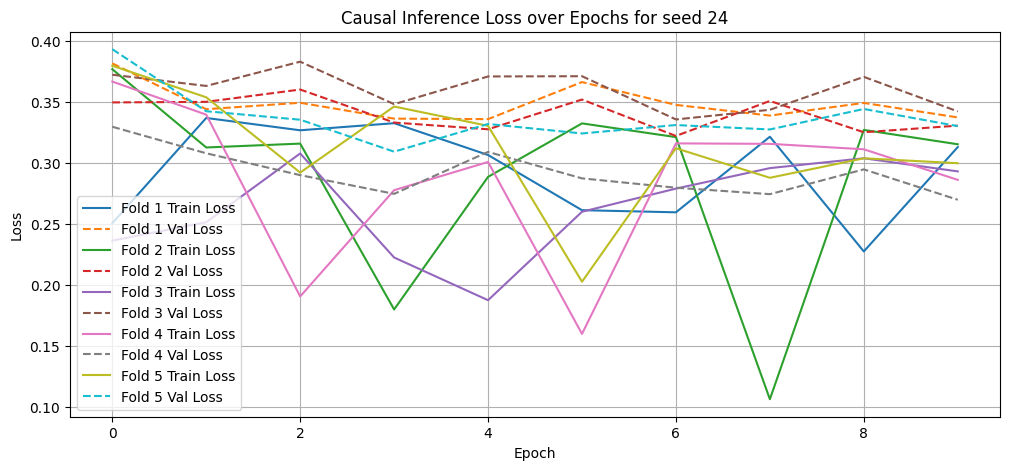

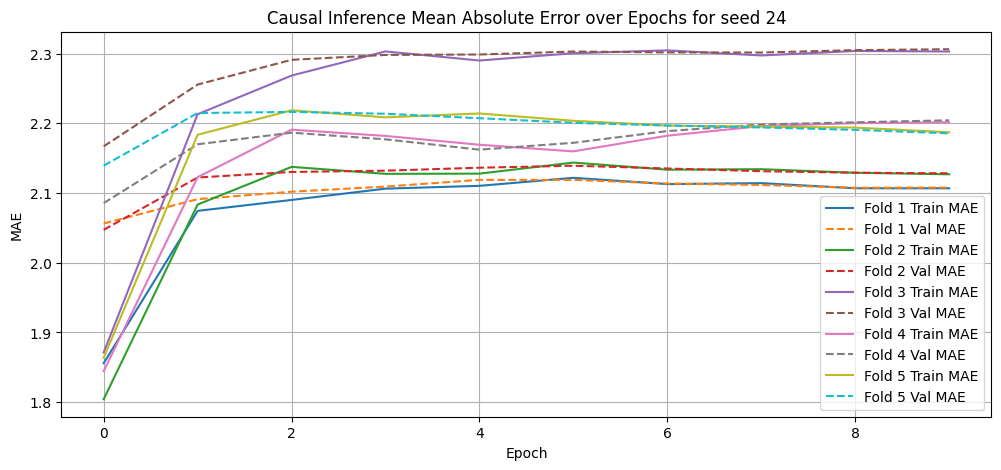

In [ ]:
#Plot results
plot_results_pe(k_folds, train_losses, val_losses_main, train_maes, val_maes_main, outputs, survival)

###Save and Load Model

In [ ]:
#Save model to file
model_path = f"Models/ci_model_{DataSeed}.pth"
model_dict_path =f"Models/ci_model_dict_{DataSeed}.pth"
torch.save(model, model_path)
torch.save(model.state_dict(), model_dict_path)

In [10]:
#Load model from file to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = f"Models/ci_model_{DataSeed}.pth"
if str(device) == 'cpu':
  model = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
else:
  model = torch.load(model_path, weights_only=False)
model.to(device)
model.eval()

SurvivalTransformerWithPE(
  (dynamic_proj): Linear(in_features=25, out_features=128, bias=True)
  (code_embedding): Linear(in_features=517, out_features=128, bias=True)
  (static_embedding): Linear(in_features=130, out_features=128, bias=True)
  (vitals_embedding): Linear(in_features=25, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_a

###Model Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    for batch in dataloader_pe:
        vitals = batch["vitals"].to(device)
        codes = batch["codes"].long().to(device)
        demographics = batch["static"].to(device)

        # Forward pass
        padding_mask = (batch["vitals"][:, :, 0] == 100).to(device)
        predictions = model(batch, padding_mask).squeeze()
        print("Predicted survival probabilities:", predictions.squeeze().cpu().numpy())
        break  # Show one batch

Predicted survival probabilities: [[0.99220735 0.98505014 0.9754212  ... 0.04253316 0.0415628  0.04061124]
 [0.99211335 0.9775922  0.9648817  ... 0.03292308 0.03208939 0.0312756 ]
 [0.997993   0.9961731  0.9942083  ... 0.18359688 0.17999607 0.17645253]
 ...
 [0.9897629  0.9688502  0.9424456  ... 0.00182344 0.0017754  0.0017287 ]
 [0.99784076 0.99558985 0.9940137  ... 0.34411243 0.3400631  0.33604681]
 [0.99737084 0.99487716 0.9921118  ... 0.15744133 0.15423845 0.15109012]]


###Obtain Treament ATE

In [11]:
#Create datasets with all patients treated and all patients control
treatment_dataset = ReadDataset(work_dir=path, seed=DataSeed, causal=True)
control_dataset = ReadDataset(work_dir=path, seed=DataSeed, causal=True)

#Replace control treatement with array of 0s
control_dataset.data['treatment'] = np.zeros(len(control_dataset.data['treatment']))
#check that all A in control are 0
assert (control_dataset.data['treatment'] == 0).all()
#Replace treatment treatment with array of 1s
treatment_dataset.data['treatment'] = np.ones(len(treatment_dataset.data['treatment']))
assert (treatment_dataset.data['treatment'] == 1).all()

In [12]:
#Method to get preditions for dataset
collate_fn = lambda x: ReadDataset.padorder(x, pad_index=-100, causal=True)
def get_predictions(model, dataset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    predictor = []
    full_predictor = []
    with torch.no_grad():
        for batch in dataloader:
            vitals = batch["vitals"].to(device)
            codes = batch["codes"].long().to(device)
            demographics = batch["static"].to(device)
            padding_mask = (batch["vitals"][:, :, 0] == 100).to(device)
            predictions = model(batch, padding_mask).squeeze()
            #Convert Hazard preditions to estimated survival times
            mask = batch["survival"] != -100
            mask = mask.to(device)
            predictions = (predictions*mask)
            full_predictor.append(predictions.cpu().numpy())
            predictions = predictions.sum(1)
            predictor.append(predictions.cpu().numpy())
    return np.concatenate(predictor), np.concatenate(full_predictor)


In [14]:
#Get predictions for dataset
treatment_predictions, treatment_full = get_predictions(model, treatment_dataset)
control_predictions, control_full = get_predictions(model, control_dataset)

#Set Random indices for ATE calculations
random_indices = np.random.choice(len(treatment_predictions), size=10, replace=False)

####Outcome Regression:
Copied from paper code

In [15]:
#Outcome Regression Estimate
taus = [20,40,60] #Paper used 8, 12, 16, this was changed here because for most patients the predicted survival time is greater than 16 hours
#Take the 10 random patients (the example uses 5)
treatment_sample = treatment_full[random_indices]
control_sample = control_full[random_indices]
for i in range(len(treatment_sample)):
  print(f"Random Patient {i+1}, Patient Number {random_indices[i]}:")
  for tau in taus:
    cutoff = torch.full(treatment_sample[0].shape, tau)
    treatment_tensor = torch.from_numpy(np.array(treatment_sample[i]))
    control_tensor = torch.from_numpy(np.array(control_sample[i]))
    ey_x1 = torch.minimum(cutoff, treatment_tensor)
    ey_x2 = torch.minimum(cutoff, control_tensor)
    print(f"tau: {tau}, ATE: {ey_x1.mean() - ey_x2.mean()}")
  print(f"Estimated survival time for patient")
  print(f"With treatment: {sum(treatment_sample[i])} hours.")
  print(f"Without treatment: {sum(control_sample[i])} hours.")
  print("")

Random Patient 1, Patient Number 23507:
tau: 20, ATE: 0.028504349291324615
tau: 40, ATE: 0.028504349291324615
tau: 60, ATE: 0.028504349291324615
Estimated survival time for patient
With treatment: 16.78352928161621 hours.
Without treatment: 13.163475036621094 hours.

Random Patient 2, Patient Number 28044:
tau: 20, ATE: 0.14235451817512512
tau: 40, ATE: 0.14235451817512512
tau: 60, ATE: 0.14235451817512512
Estimated survival time for patient
With treatment: 71.29045104980469 hours.
Without treatment: 53.21143341064453 hours.

Random Patient 3, Patient Number 3196:
tau: 20, ATE: 0.05378285050392151
tau: 40, ATE: 0.05378285050392151
tau: 60, ATE: 0.05378285050392151
Estimated survival time for patient
With treatment: 49.30029296875 hours.
Without treatment: 42.4698600769043 hours.

Random Patient 4, Patient Number 21899:
tau: 20, ATE: 0.021717548370361328
tau: 40, ATE: 0.021717548370361328
tau: 60, ATE: 0.021717548370361328
Estimated survival time for patient
With treatment: 66.868568420

Restricted Mean Survival Time

In [16]:
#Root Mean Survival Time

#save results to file
with open(f"Outputs/ci_ATE_{DataSeed}.txt", "w") as f:
#Calculate Root Mean Survival Time
  taus = [8, 12, 16, 20, 24]
  for tau in taus:
    rmst = 0
    for i in range(len(treatment_full)):
      rmst += sum(treatment_full[i][0:tau])
    rmst = rmst/len(treatment_full)
    cutoff = torch.full(treatment_full[0].shape, tau)
    treatment_tensor = torch.from_numpy(np.array(sum(treatment_full[:][0:tau])))
    control_tensor = torch.from_numpy(np.array(sum(control_full[:][0:tau])))
    ey_x1 = torch.minimum(cutoff, treatment_tensor)
    ey_x2 = torch.minimum(cutoff, control_tensor)
    ate = ey_x1.mean() - ey_x2.mean()
    print(f"Cutoff: {tau} hours, RMST: {rmst} hours, ATE: {ate}")
    f.write(f"Cutoff: {tau} hours, RMST: {rmst} hours, ATE: {ate}\n")


  print("")
  f.write("\n")
  print("///////////////////////")
  f.write("///////////////////////\n")
  print("")
  f.write("\n")

  treatment_sample = treatment_full[random_indices]
  control_sample = control_full[random_indices]
  for i in range(len(treatment_sample)):
    print(f"Random Patient {i+1}, Patient Number {random_indices[i]}:")
    f.write(f"Random Patient {i+1}, Patient Number {random_indices[i]}\n")
    for tau in taus:
      cutoff = torch.full(treatment_full[0].shape, tau)
      treatment_tensor = torch.from_numpy(np.array(sum(treatment_sample[i][0:tau])))
      control_tensor = torch.from_numpy(np.array(sum(control_sample[i][0:tau])))
      ey_x1 = torch.minimum(cutoff, treatment_tensor)
      ey_x2 = torch.minimum(cutoff, control_tensor)
      print(f"tau: {tau}, ATE: {ey_x1.mean() - ey_x2.mean()}")
      f.write(f"tau: {tau}, ATE: {ey_x1.mean() - ey_x2.mean()}\n")
    print(f"Estimated survival time for patient")
    f.write(f"Estimated survival time for patient\n")
    print(f"With treatment: {sum(treatment_sample[i])} hours.")
    f.write(f"With treatment: {sum(treatment_sample[i])} hours.\n")
    print(f"Without treatment: {sum(control_sample[i])} hours.")
    f.write(f"Without treatment: {sum(control_sample[i])} hours.\n")
    print("")
    f.write("\n")

Cutoff: 8 hours, RMST: 7.4263153076171875 hours, ATE: 0.32134485244750977
Cutoff: 12 hours, RMST: 10.689048767089844 hours, ATE: 0.4103872776031494
Cutoff: 16 hours, RMST: 13.655399322509766 hours, ATE: 0.5391759872436523
Cutoff: 20 hours, RMST: 16.326990127563477 hours, ATE: 0.6661312580108643
Cutoff: 24 hours, RMST: 18.601402282714844 hours, ATE: 0.8871150016784668

///////////////////////

Random Patient 1, Patient Number 23507:
tau: 8, ATE: 0.4557976722717285
tau: 12, ATE: 0.987640380859375
tau: 16, ATE: 1.6117620468139648
tau: 20, ATE: 2.253176689147949
tau: 24, ATE: 2.8796825408935547
Estimated survival time for patient
With treatment: 16.78352928161621 hours.
Without treatment: 13.163475036621094 hours.

Random Patient 2, Patient Number 28044:
tau: 8, ATE: 0.09572362899780273
tau: 12, ATE: 0.2319316864013672
tau: 16, ATE: 0.44109344482421875
tau: 20, ATE: 0.7131214141845703
tau: 24, ATE: 1.0594940185546875
Estimated survival time for patient
With treatment: 71.29045104980469 hou